# Modelo Matemático del Problema de Optimización de Sensores en Ciudades Inteligentes

## Conjuntos

- **L**: Conjunto de ubicaciones que necesitan ser monitoreadas.

  $$
  L = \\{ \text{L1}, \text{L2}, \text{L3}, \dots, \text{L12} \\}
  $$

- **S**: Conjunto de sensores disponibles para su instalación.

  $$
  S = \\{ \text{S1}, \text{S2}, \text{S3} \\}
  $$

## Parámetros

- **sensor\_coverage\_{s,l}**: Parámetro binario que indica si el sensor \( s \) puede cubrir la ubicación \( l \).

  $$
  sensor\_coverage_{s,l} =
  \begin{cases}
      1, & \text{si el sensor } s \text{ puede cubrir la ubicación } l \\
      0, & \text{en caso contrario}
  \end{cases}
  $$

- **adj\_{l',l}**: Parámetro binario que indica si la ubicación \( l' \) es adyacente a la ubicación \( l \) o es la misma ubicación.

  $$
  adj_{l',l} =
  \begin{cases}
      1, & \text{si } l' = l \text{ o } l' \text{ es adyacente a } l \\
      0, & \text{en caso contrario}
  \end{cases}
  $$

- **energy\_consumption\_s**: Costo del consumo de energía del sensor \( s \).

- **communication\_cost\_{s,l}**: Costo de comunicación del sensor \( s \) en la ubicación \( l \).

- **installation\_cost\_l**: Costo de instalación en la ubicación \( l \).

## Variables de Decisión

- **\( x_{s,l} \in \\{0,1\\} \)**: Variable binaria que indica si el sensor \( s \) es instalado en la ubicación \( l \).

  $$
  x_{s,l} =
  \begin{cases}
      1, & \text{si el sensor } s \text{ es instalado en } l \\
      0, & \text{en caso contrario}
  \end{cases}
  $$

- **\( z_l \in \\{0,1\\} \)**: Variable binaria que indica si se instala algún sensor en la ubicación \( l \).

  $$
  z_l =
  \begin{cases}
      1, & \text{si se instala al menos un sensor en } l \\
      0, & \text{en caso contrario}
  \end{cases}
  $$

## Función Objetivo

Minimizar el costo total, que incluye los costos de instalación, consumo de energía y comunicación:

$$
\min \left( \sum_{l \in L} installation\_cost_l \cdot z_l + \sum_{s \in S} \sum_{l \in L} x_{s,l} \cdot \left( energy\_consumption_s + communication\_cost_{s,l} \right) \right)
$$

## Restricciones

1. **Restricción de Cobertura**

   Cada ubicación debe estar cubierta por al menos un sensor instalado en ella o en una ubicación adyacente:

   $$
   \sum_{s \in S} \sum_{l' \in L} x_{s,l'} \cdot sensor\_coverage_{s,l'} \cdot adj_{l',l} \geq 1, \quad \forall l \in L
   $$

2. **Relación entre \( x_{s,l} \) y \( z_l \)**

   Si se instala un sensor en la ubicación \( l \), entonces \( z_l \) debe ser 1:

   $$
   x_{s,l} \leq z_l, \quad \forall s \in S, \forall l \in L
   $$

3. **Variables Binarias**

   $$
   x_{s,l} \in \\{0,1\\}, \quad \forall s \in S, \forall l \in L
   $$

   $$
   z_l \in \\{0,1\\}, \quad \forall l \in L
   $$

## Descripción de los Parámetros y Variables

- **sensor\_coverage\_{s,l}**: Indica si el sensor \( s \) tiene la capacidad de cubrir la ubicación \( l \) cuando está instalado.

- **adj\_{l',l}**: Indica si la ubicación \( l' \) puede proporcionar cobertura a la ubicación \( l \), ya sea porque es la misma ubicación o porque es adyacente.

- **energy\_consumption\_s**: Costo asociado al consumo de energía del sensor \( s \).

- **communication\_cost\_{s,l}**: Costo asociado a la comunicación del sensor \( s \) cu


# Codigo sin modificar

In [ ]:

import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


model = pyo.ConcreteModel()

# --- Conjunto de Sensores ---
model.S = pyo.Set(initialize=['S1', 'S2', 'S3'])

# --- Conjunto de Ubicaciones ---
locations_list = ['L{}'.format(i) for i in range(1, 13)]
model.L = pyo.Set(initialize=locations_list)

# --- Parámetros ---

# 1. Cobertura de Sensores: sensor_coverage[s,l]
sensor_coverage_df = pd.read_csv('Lab2/sensor_coverage.csv')
sensor_coverage_dict = {}
for idx, row in sensor_coverage_df.iterrows():
    l = row['Location']
    for s in model.S:
        sensor_coverage_dict[(s, l)] = row[s]

def sensor_coverage_init(model, s, l):
    return sensor_coverage_dict.get((s, l), 0)
model.sensor_coverage = pyo.Param(model.S, model.L, initialize=sensor_coverage_init, within=pyo.Binary)

# 2. Consumo de Energía: energy_consumption[s]
energy_consumption_df = pd.read_csv('Lab2/energy_consumption.csv')
energy_consumption_dict = energy_consumption_df.set_index('SensorType')['EnergyConsumption'].to_dict()
model.energy_consumption = pyo.Param(model.S, initialize=energy_consumption_dict)

# 3. Costo de Comunicación: communication_cost[s,l]
communication_cost_df = pd.read_csv('Lab2/communication_costs.csv')
communication_cost_dict = communication_cost_df.set_index(['SensorType', 'Location'])['CommunicationCost'].to_dict()

def communication_cost_init(model, s, l):
    return communication_cost_dict.get((s, l), 0)
model.communication_cost = pyo.Param(model.S, model.L, initialize=communication_cost_init)

# 4. Costo de Instalación: installation_cost[l]
installation_cost_df = pd.read_csv('Lab2/installation_costs.csv')
installation_cost_dict = installation_cost_df.set_index('Location')['InstallationCost'].to_dict()
model.installation_cost = pyo.Param(model.L, initialize=installation_cost_dict)

# 5. Cobertura de Zonas (Adyacencia): adj[l,l']
# Definir el diccionario de adyacencia
adjacency_dict = {
    ('L1', 'L1'): 1, ('L1', 'L2'): 1, ('L1', 'L3'): 1,
    ('L2', 'L1'): 1, ('L2', 'L2'): 1, ('L2', 'L4'): 1,
    ('L3', 'L1'): 1, ('L3', 'L3'): 1, ('L3', 'L5'): 1,
    ('L4', 'L2'): 1, ('L4', 'L4'): 1, ('L4', 'L6'): 1,
    ('L5', 'L3'): 1, ('L5', 'L5'): 1, ('L5', 'L6'): 1, ('L5', 'L7'): 1,
    ('L6', 'L4'): 1, ('L6', 'L5'): 1, ('L6', 'L6'): 1, ('L6', 'L8'): 1,
    ('L7', 'L5'): 1, ('L7', 'L7'): 1, ('L7', 'L9'): 1,
    ('L8', 'L6'): 1, ('L8', 'L8'): 1, ('L8', 'L9'): 1, ('L8', 'L10'): 1,
    ('L9', 'L7'): 1, ('L9', 'L8'): 1, ('L9', 'L9'): 1, ('L9', 'L11'): 1,
    ('L10', 'L8'): 1, ('L10', 'L10'): 1, ('L10', 'L11'): 1, ('L10', 'L12'): 1,
    ('L11', 'L9'): 1, ('L11', 'L10'): 1, ('L11', 'L11'): 1,
    ('L12', 'L10'): 1, ('L12', 'L12'): 1,
}

def adj_init(model, l1, l2):
    return adjacency_dict.get((l1, l2), 0)
model.adj = pyo.Param(model.L, model.L, initialize=adj_init, within=pyo.Binary)

# ======================
# Variables de Decisión
# ======================

# Variable binaria x[s,l]: 1 si el sensor s se instala en la ubicación l
model.x = pyo.Var(model.S, model.L, within=pyo.Binary)

# Variable binaria z[l]: 1 si se instala algún sensor en la ubicación l
model.z = pyo.Var(model.L, within=pyo.Binary)

# ======================
# Función Objetivo
# ======================

def objective_rule(model):
    # Costo total de instalación por ubicación
    installation_cost = sum(model.installation_cost[l] * model.z[l] for l in model.L)
    # Costo total de energía y comunicación por sensor instalado
    operational_cost = sum(
        model.x[s, l] * (model.energy_consumption[s] + model.communication_cost[s, l])
        for s in model.S for l in model.L
    )
    return installation_cost + operational_cost
model.TotalCost = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# ======================
# Restricciones
# ======================

# 1. Restricción de Cobertura: Cada ubicación debe ser cubierta al menos por un sensor
def coverage_constraint_rule(model, l):
    return sum(
        model.x[s, l_prime] * model.sensor_coverage[s, l_prime] * model.adj[l_prime, l]
        for s in model.S for l_prime in model.L
    ) >= 1
model.CoverageConstraint = pyo.Constraint(model.L, rule=coverage_constraint_rule)

# 2. Relación entre x[s,l] y z[l]: Si un sensor se instala en l, entonces z[l] = 1
def x_z_relation_rule(model, s, l):
    return model.x[s, l] <= model.z[l]
model.XZRelationConstraint = pyo.Constraint(model.S, model.L, rule=x_z_relation_rule)

# ======================
# Configuración y Resolución del Modelo
# ======================

solver = SolverFactory('glpk')

# Resolver el modelo
results = solver.solve(model, tee=True)

# ======================
# Mostrar Resultados
# ======================

print(f"\nCosto Total: {pyo.value(model.TotalCost)}")

print("\nSensores instalados en las ubicaciones:")
for s in model.S:
    for l in model.L:
        if pyo.value(model.x[s, l]) > 0.5:
            print(f"Sensor {s} instalado en la Ubicación {l}")

print("\nUbicaciones con sensores instalados:")
for l in model.L:
    if pyo.value(model.z[l]) > 0.5:
        print(f"Ubicación {l}")

# ======================
# Obtener los resultados del modelo para graficar
# ======================

sensors_installed = {}
for l in model.L:
    for s in model.S:
        if pyo.value(model.x[s, l]) > 0.5:
            sensors_installed[l] = s



# ======================
# Graficar la distribución de sensores
# ======================


locations = ['L{}'.format(i) for i in range(1, 13)]

edges = [
    ('L1', 'L2'), ('L1', 'L3'),
    ('L2', 'L4'),
    ('L3', 'L5'),
    ('L4', 'L6'),
    ('L5', 'L6'), ('L5', 'L7'),
    ('L6', 'L8'),
    ('L7', 'L9'),
    ('L8', 'L9'), ('L8', 'L10'),
    ('L9', 'L11'),
    ('L10', 'L11'), ('L10', 'L12'),

]

G = nx.Graph()
G.add_nodes_from(locations)
G.add_edges_from(edges)


sensor_colors = {
    'S1': 'red',
    'S2': 'green',
    'S3': 'blue',
}

node_colors = []
for node in G.nodes():
    if node in sensors_installed:
        sensor_type = sensors_installed[node]
        color = sensor_colors.get(sensor_type, 'yellow')
    else:
        color = 'gray'
    node_colors.append(color)


pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sin Sensor', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S1', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S2', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S3', markerfacecolor='blue', markersize=10),
]

plt.legend(handles=legend_elements, loc='best')

plt.title('Distribución de Sensores en Smartville')
plt.axis('off')
plt.show()


1. Costo Total
Costo Total: 740.0 unidades monetarias

2. Sensores Instalados en las Ubicaciones
Sensor S1 instalado en la Ubicación L10
Sensor S2 instalado en la Ubicación L5
Sensor S3 instalado en la Ubicación L2
Sensor S3 instalado en la Ubicación L11
3. Ubicaciones con Sensores Instalados
L2
L5
L10
L11

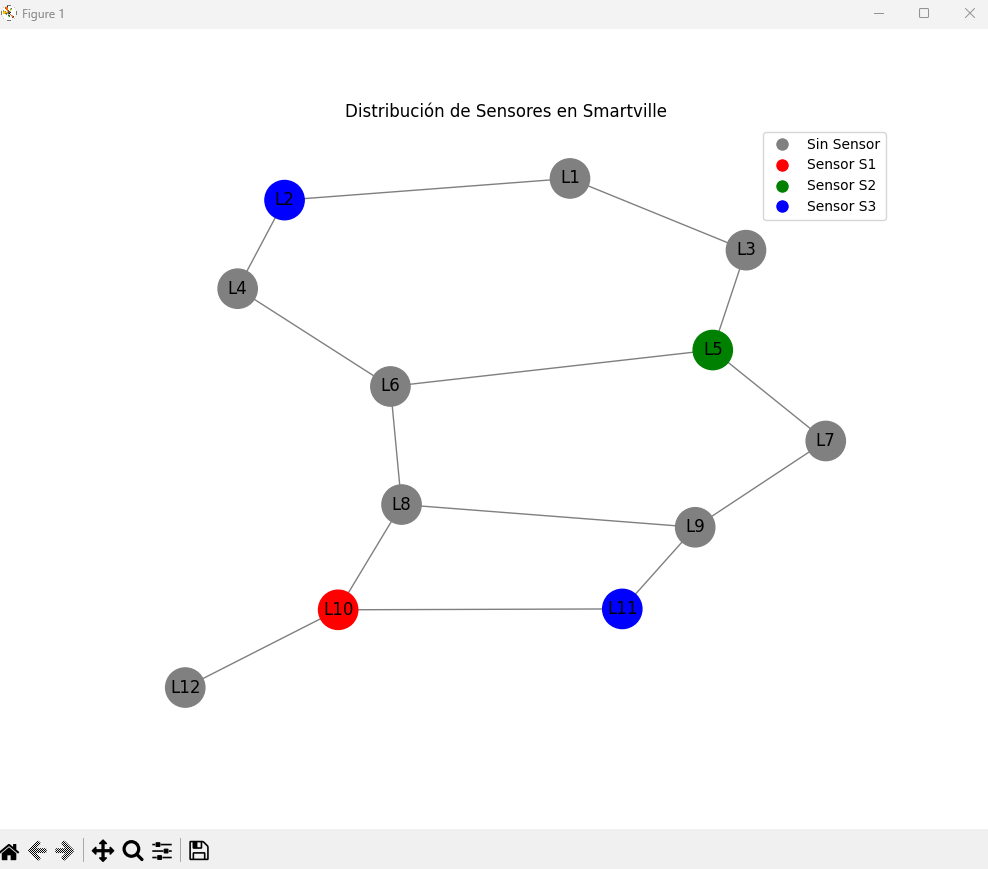

En la grafica podemos interpretar de forma visual que se escogieron los nodos L2 L5 L10 L11 y con esta ayuda grafica tambien pudimos hacer la version manual de los calculos para estas listas de adjacencia que cuenta los parámetros clave del proyecto: minimizar costos de instalación, consumo de energía, y costos de comunicación, mientras se garantiza una cobertura efectiva de las áreas críticas de Smartville

# Con modificaciones


In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Crear un modelo concreto de Pyomo
model = pyo.ConcreteModel()

# --- Conjunto de Sensores ---
model.S = pyo.Set(initialize=['S1', 'S2', 'S3'])

# --- Conjunto de Ubicaciones ---
locations_list = ['L{}'.format(i) for i in range(1, 13)]
model.L = pyo.Set(initialize=locations_list)

# --- Parámetros ---

# 1. Cobertura de Sensores: sensor_coverage[s,l]
sensor_coverage_df = pd.read_csv('Lab2/sensor_coverage.csv')
sensor_coverage_dict = {}
for idx, row in sensor_coverage_df.iterrows():
    l = row['Location']
    for s in model.S:
        sensor_coverage_dict[(s, l)] = row[s]

def sensor_coverage_init(model, s, l):
    return sensor_coverage_dict.get((s, l), 0)
model.sensor_coverage = pyo.Param(model.S, model.L, initialize=sensor_coverage_init, within=pyo.Binary)

# 2. Consumo de Energía: energy_consumption[s]
energy_consumption_df = pd.read_csv('Lab2/energy_consumption.csv')
energy_consumption_dict = energy_consumption_df.set_index('SensorType')['EnergyConsumption'].to_dict()
model.energy_consumption = pyo.Param(model.S, initialize=energy_consumption_dict)

# 3. Costo de Comunicación: communication_cost[s,l]
communication_cost_df = pd.read_csv('Lab2/communication_costs.csv')
communication_cost_dict = communication_cost_df.set_index(['SensorType', 'Location'])['CommunicationCost'].to_dict()

def communication_cost_init(model, s, l):
    return communication_cost_dict.get((s, l), 0)
model.communication_cost = pyo.Param(model.S, model.L, initialize=communication_cost_init)

# 4. Costo de Instalación: installation_cost[l]
installation_cost_df = pd.read_csv('Lab2/installation_costs.csv')
installation_cost_dict = installation_cost_df.set_index('Location')['InstallationCost'].to_dict()
model.installation_cost = pyo.Param(model.L, initialize=installation_cost_dict)

# 5. Cobertura de Zonas (Adyacencia): adj[l,l']
# Definir el diccionario de adyacencia
adjacency_dict = {
    ('L1', 'L1'): 1, ('L1', 'L2'): 1, ('L1', 'L3'): 1,
    ('L2', 'L1'): 1, ('L2', 'L2'): 1, ('L2', 'L4'): 1,
    ('L3', 'L1'): 1, ('L3', 'L3'): 1, ('L3', 'L5'): 1,
    ('L4', 'L2'): 1, ('L4', 'L4'): 1, ('L4', 'L6'): 1,
    ('L5', 'L3'): 1, ('L5', 'L5'): 1, ('L5', 'L6'): 1, ('L5', 'L7'): 1,
    ('L6', 'L4'): 1, ('L6', 'L5'): 1, ('L6', 'L6'): 1, ('L6', 'L8'): 1,
    ('L7', 'L5'): 1, ('L7', 'L7'): 1, ('L7', 'L9'): 1,
    ('L8', 'L6'): 1, ('L8', 'L8'): 1, ('L8', 'L9'): 1, ('L8', 'L10'): 1,
    ('L9', 'L7'): 1, ('L9', 'L8'): 1, ('L9', 'L9'): 1, ('L9', 'L11'): 1,
    ('L10', 'L8'): 1, ('L10', 'L10'): 1, ('L10', 'L11'): 1, ('L10', 'L12'): 1,
    ('L11', 'L9'): 1, ('L11', 'L10'): 1, ('L11', 'L11'): 1,
    ('L12', 'L10'): 1, ('L12', 'L12'): 1,
}

def adj_init(model, l1, l2):
    return adjacency_dict.get((l1, l2), 0)
model.adj = pyo.Param(model.L, model.L, initialize=adj_init, within=pyo.Binary)

# ======================
# Variables de Decisión
# ======================

# Variable binaria x[s,l]: 1 si el sensor s se instala en la ubicación l
model.x = pyo.Var(model.S, model.L, within=pyo.Binary)

# Variable binaria z[l]: 1 si se instala algún sensor en la ubicación l
model.z = pyo.Var(model.L, within=pyo.Binary)

# ======================
# Función Objetivo (Solo Costos de Instalación)
# ======================

def objective_rule(model):
    # Costo total de instalación por ubicación
    installation_cost = sum(model.installation_cost[l] * model.z[l] for l in model.L)
    return installation_cost
model.TotalCost = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# ======================
# Restricciones
# ======================

# 1. Restricción de Cobertura: Cada ubicación debe ser cubierta al menos por un sensor
def coverage_constraint_rule(model, l):
    return sum(
        model.x[s, l_prime] * model.sensor_coverage[s, l_prime] * model.adj[l_prime, l]
        for s in model.S for l_prime in model.L
    ) >= 1
model.CoverageConstraint = pyo.Constraint(model.L, rule=coverage_constraint_rule)

# 2. Relación entre x[s,l] y z[l]: Si un sensor se instala en l, entonces z[l] = 1
def x_z_relation_rule(model, s, l):
    return model.x[s, l] <= model.z[l]
model.XZRelationConstraint = pyo.Constraint(model.S, model.L, rule=x_z_relation_rule)


solver = SolverFactory('glpk')

# Resolver el modelo
results = solver.solve(model, tee=True)



print(f"\nCosto Total (Solo Instalación): {pyo.value(model.TotalCost)}")

print("\nSensores instalados en las ubicaciones:")
for s in model.S:
    for l in model.L:
        if pyo.value(model.x[s, l]) > 0.5:
            print(f"Sensor {s} instalado en la Ubicación {l}")

print("\nUbicaciones con sensores instalados:")
for l in model.L:
    if pyo.value(model.z[l]) > 0.5:
        print(f"Ubicación {l}")


locations = ['L{}'.format(i) for i in range(1, 13)]

edges = [
    ('L1', 'L2'), ('L1', 'L3'),
    ('L2', 'L4'),
    ('L3', 'L5'),
    ('L4', 'L6'),
    ('L5', 'L6'), ('L5', 'L7'),
    ('L6', 'L8'),
    ('L7', 'L9'),
    ('L8', 'L9'), ('L8', 'L10'),
    ('L9', 'L11'),
    ('L10', 'L11'), ('L10', 'L12'),

]

G = nx.Graph()
G.add_nodes_from(locations)
G.add_edges_from(edges)


sensor_colors = {
    'S1': 'red',
    'S2': 'green',
    'S3': 'blue',
}



sensors_installed = {}
for l in model.L:
    for s in model.S:
        if pyo.value(model.x[s, l]) > 0.5:
            sensors_installed[l] = s

node_colors = []
for node in G.nodes():
    if node in sensors_installed:
        sensor_type = sensors_installed[node]
        color = sensor_colors.get(sensor_type, 'yellow')
    else:
        color = 'gray'
    node_colors.append(color)


pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sin Sensor', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S1', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S2', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sensor S3', markerfacecolor='blue', markersize=10),
]

plt.legend(handles=legend_elements, loc='best')

plt.title('Distribución de Sensores en Smartville')
plt.axis('off')
plt.show()




Costo Total: 630.0 unidades monetarias                     

Sensores Instalados en las Ubicaciones
Sensor S1 instalado en la Ubicación L2
Sensor S1 instalado en la Ubicación L5
Sensor S1 instalado en la Ubicación L10
Sensor S1 instalado en la Ubicación L11
Sensor S2 instalado en la Ubicación L5
Sensor S2 instalado en la Ubicación L10
Sensor S3 instalado en la Ubicación L2
Sensor S3 instalado en la Ubicación L5
Sensor S3 instalado en la Ubicación L11           


Ubicaciones con Sensores Instalados
L2
L5
L10
L11


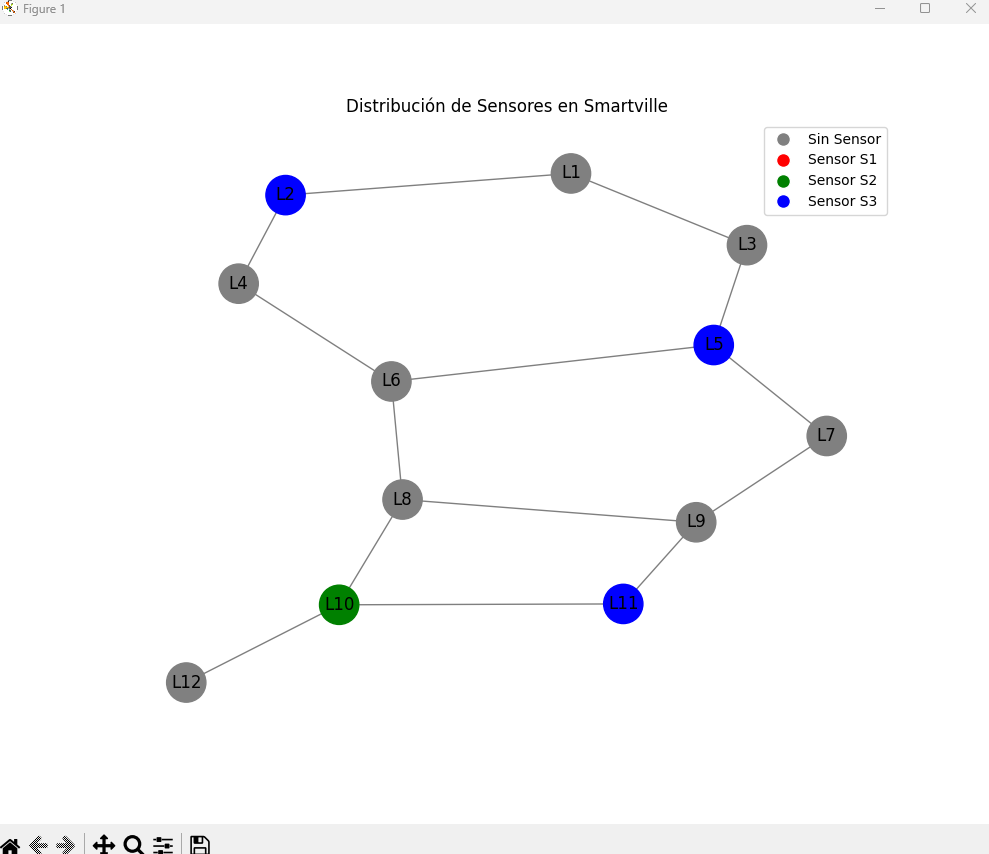

En la gráfica podemos interpretar de forma visual que se escogieron los nodos L2, L5, y L10 para la instalación de sensores. Esta representación gráfica nos permite observar de manera clara cómo se distribuyen los sensores en estas ubicaciones. Además, con esta ayuda gráfica también podríamos realizar de forma manual los cálculos relacionados con las listas de adyacencia, tomando en cuenta los parámetros clave del proyecto: minimizar los costos de instalación mientras se busca proporcionar una cobertura efectiva de las áreas críticas de Smartville.








**Diferencias**

La principal diferencia que encontramos entre los resultados de ambas configuraciones radica en la selección de los nodos para la instalación de sensores, específicamente al comparar las estrategias de optimización. En la primera solución, donde se consideraron múltiples factores como el consumo de energía y los costos de comunicación, se instalaron sensores en los nodos L2, L5, L10, y L11, logrando una cobertura más amplia de las áreas críticas en Smartville. Sin embargo, al ejecutar el modelo nuevamente, teniendo en cuenta únicamente el costo de instalación en la función objetivo, observamos que los sensores solo se instalaron en los nodos L2, L5, y L10. Este resultado sugiere que, al priorizar únicamente los costos de instalación, logramos reducir el número total de sensores utilizados, lo que disminuye el gasto directo, pero con el sacrificio de cobertura, como en el caso del nodo L11, que fue excluido en la nueva solución.

Este hallazgo es relevante dentro del contexto del proyecto de Smartville, ya que el objetivo es optimizar la red de sensores minimizando costos, pero sin comprometer la efectividad del monitoreo de zonas adyacentes y áreas críticas. En esta segunda configuración, al ignorar los costos de energía y comunicación, la red propuesta se centra en una solución más económica en términos de instalación, lo que reduce la cantidad de sensores y el costo neto total. Sin embargo, como se observa en el nodo L11, esto podría llevar a áreas menos cubiertas, lo que podría impactar la calidad y eficiencia del monitoreo de la ciudad. En conclusión, aunque esta estrategia reduce los costos iniciales, podría no ser la más adecuada si se busca una cobertura completa y efectiva a largo plazo en Smartville.